# op.gg 크롤링
## 간단 코드설명
- 위쪽 블록 :   
사이트에서 selenium을 이용하여 동적웹로딩후 html변수에 html 코드저장

- 아래쪽 블록 :   
beautifulsoup를 이용하여 코드 분석 및 판다스를 이용한 데이터 프레임 생성
matplotlib로 승률 파이차트 생성

## 샐레니움을 활용한 부분 작동방식
1. 사용자로부터 리그오브레전드의 닉네임을 받아서 op.gg 사이트에 접속을 합니다.    
2. 마지막 업데이트 시간을 확인하여 시간, 일, 하루 전 일때 전적갱신 버튼을 누릅니다.   
3. 스크롤을 맨 아래로 내려 더보기 버튼을 더 못찾을 때까지 누르거나 2000게임이 로딩 될때까지 누릅니다(더보기 누를때마다 20게임씩 로딩)
4. 로딩이 되었다면 html로 저장을 합니다

In [2]:
import re
import time
from bs4 import BeautifulSoup
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.by import By


nickname = input('op.gg 사이트에서 검색할 닉네임을 입력해주세요 : \n')
url = f'https://www.op.gg/summoners/kr/{nickname}'

# Chrome 드라이버 경로 설정
driver = webdriver.Chrome()

# op.gg 웹 사이트로 이동
print('로딩중...')
driver.get(url)
look = driver.find_element(By.XPATH, '//*[@id="content-header"]/div[1]/div/div[1]/div[2]/div[5]/div').text

print(look)
#re를 이용해서 1시간 전, 1일 전, 하루 전이라는 문자열이 있으면 데이터를 최신화 시킨다.
if re.search(r'(\d+\s*시간|\d+\s*일|하루)\s*전', look):
    driver.find_element(By.XPATH, '//*[@id="content-header"]/div[1]/div/div[1]/div[2]/div[4]/button').click()
    print('데이터 최신화 중...')
    new = tqdm(range(5),desc='5초 소요',leave=False)
    for i in new:
        time.sleep(1)
    new.close()
        
#가장아래로 스크롤을 내린다.
driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
time.sleep(0.5)

#더보기 버튼이 더이상 나오지 않을때까지누른다.
for i in range(1, 100):
    try:
        more_button = driver.find_element(By.XPATH, '//*[@id="content-container"]/div[2]/button')
        more_button.click()
        print('게임 로드중...')
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(2)
    except:
        print("더이상 찾을 데이터가 없습니다.")
        break

    
print('완료')

html = driver.page_source
# print('파일저장중')
# f = open('/Users/dryoon/Documents/schoolproject/all.html','w')
# f.write(html)
# f.close() 
# print('저장완료!')
driver.quit()





로딩중...
최근 업데이트: 11시간 전
데이터 최신화 중...


5초 소요:   0%|          | 0/5 [00:00<?, ?it/s]

게임 로드중...
게임 로드중...
더이상 찾을 데이터가 없습니다.
완료


## Beautiful Soup을 사용한 주요 로직   
1. 윗 코드에서 html을 받으면 플레이한 게임의 수를 샙니다.  
2. 승패기록을 가져와서 데이터 프레임에 저장합니다.
3. k/d/a를 가져와서 데이터 프레임에 저장합니다.
4. 승률을 계산합니다.(승리횟수/전체게임횟수-다시하기 판수)
5. 아까 생성한 두 데이터 프레임을 한개의 데이터프레임으로 만듭니다.
6. csv형태로 파일을 저장합니다.
7. 파이차트로 승리 비율과 패배 비율을 출력합니다.

가져온 게임의 판수는 54판 입니다
승리 : 21 판
패배 : 32 판
다시하기 : 1 판
승률 : 39.62%
      결과
0     승리
1     승리
2     패배
3     승리
4     패배
5     패배
6     패배
7     패배
8     패배
9     패배
10    승리
11    패배
12    패배
13    패배
14    승리
15    패배
16    패배
17    패배
18    승리
19    승리
20    승리
21  다시하기
22    승리
23    패배
24    패배
25    패배
26    승리
27    패배
28    패배
29    승리
30    승리
31    승리
32    패배
33    패배
34    승리
35    패배
36    패배
37    승리
38    패배
39    패배
40    패배
41    승리
42    패배
43    승리
44    승리
45    패배
46    승리
47    승리
48    패배
49    패배
50    승리
51    패배
52    패배
53    패배


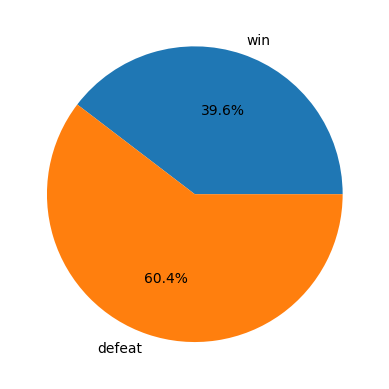

In [3]:
# # 파일 열기 (읽기 모드)
# file_path = "/Users/dryoon/Documents/schoolproject/all.html"  # 파일 경로를 지정합니다.
# file = open(file_path, "r")


soup = BeautifulSoup(html, 'html.parser')
# "game-content" 클래스 선택
game_content = soup.select('div.game-content')

#가져온 게임수 세기
recent_game_len = len(game_content)
print(f'가져온 게임의 판수는 {recent_game_len}판 입니다')

# 승패가져와서 데이터프레임으로 저장
result_all = soup.find_all(class_="result")
result_values = [result.get_text() for result in result_all]
df_result = pd.DataFrame({'결과': result_values})
#승리와 패베 개수샘
result_num = df_result['결과'].value_counts()

#kda 가져와서 데이터프레임으로 저장
result_kda = soup.find_all(class_="k-d-a")
kda_values = [kdaresult.get_text() for kdaresult in result_kda]
del kda_values[0]
df_kda = pd.DataFrame({'k/d/a': kda_values},index=None)

try:
    print(f"승리 : {result_num['승리']} 판")
    print(f"패배 : {result_num['패배']} 판")
    try:
        print(f"다시하기 : {result_num['다시하기']} 판")
    except:
        pass
    winrate = "%0.2f"%((result_num["승리"]/(result_num['승리']+result_num['패배']))*100)
    print(f'승률 : {winrate}%')
    print(df_result)
except:
    print(f'총게임수는{recent_game_len}입니다.')
    print('승률은 0%입니다')




# 데이터프레임 인덱스 초기화
if len(df_result) != len(df_kda):
    df_result = df_result.reset_index(drop=True)
    df_kda = df_kda.reset_index(drop=True)



# 두 데이터프레임 합치기
merged_df = pd.concat([df_result, df_kda], axis=1)

# 결과를 엑셀 파일로 저장
merged_df.to_excel('merged_df.xlsx', index=False)

# 승패 비율
ratio = [result_num['승리'],result_num['패배']]
labels = ['win', 'defeat']

# 승패 비율 그래프
plt.pie(ratio, labels=labels, autopct='%.1f%%')
plt.show()

## 정리
1. 셀레니움만을 이용하여 크롤링이 가능하다는것을 알게됨
2. 셀레니움을 이용하여 크롤링을 하면 속도가 느리다는것을 알게됨  
개인적인 생각으로는 동적인 웹인경우는 셀레니움을 이용해서 html을 파싱후 beautifulsoup을 이용하여 데이터를 가져오는것이 가장 이상적이라고 생각이 됨.   
정적인 웹이더라도 크롤링이 막혀있는 경우가 있기때문에 셀레니움와 beautifulsoup을 동시에 알고있는것이 좋다고 생각됨.